In [ ]:
!nvidia-smi

Tue Apr 20 07:24:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00223657days (193.24sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 13.5MB/s 


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/retina_10random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!7z x retina_10random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2888291374 bytes (2755 MiB)

Extracting archive: retina_10random_ImagenetTrain.zip
  2% 4096 Open              --
Path = retina_10random_ImagenetTrain.zip
Type = zip
Physical Size = 2888291374
64-bit = +

  0%      0% 564 - content/retina_ImagenetTrain/pineapple/pineapple_2995.jpg                                                                      0% 963 - content/retina_ImagenetTrain/pineapple/pineapple_4384.jpg                                                                    

In [ ]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     40% 824 - content/retina_ImagenetTest/bell_pepper/bell_pepper_015.jpg                                                                       80% 1637 - content/retina_ImagenetTest/cauliflower/cauliflower_027.jpg                                                                       

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


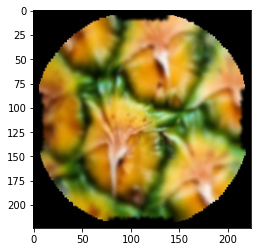

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### Network model

In [ ]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """

    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128 * 14 * 14, 100), nn.Dropout2d(p=0.5), self.relu,
                                  nn.Linear(100, 20), nn.Dropout2d(p=0.4))
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.encode(x)

        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return self.relu(x)

### Model preparation

In [ ]:
# TinyCNN model instance set
model=TinyCNN()

# FC layer input&output size change
#model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
#model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=100, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): Dropout2d(p=0.4, inplace=False)
  )
)

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 40

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "05_3_simple"
folder_name = "simple"

stats=[]; 
if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model=model
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    model.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=model;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    epochs=0;


In [39]:
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/40
-------------



train Loss: 0.0885 Acc: 16.1173



val Loss: 0.0810 Acc: 28.3228
-------------
Epoch 2/40
-------------



train Loss: 0.0844 Acc: 21.2562



val Loss: 0.0776 Acc: 32.9707
-------------
Epoch 3/40
-------------



train Loss: 0.0823 Acc: 23.5548



val Loss: 0.0750 Acc: 35.9036
-------------
Epoch 4/40
-------------



train Loss: 0.0806 Acc: 25.5623



val Loss: 0.0748 Acc: 36.9547
-------------
Epoch 5/40
-------------



train Loss: 0.0794 Acc: 27.1947



val Loss: 0.0705 Acc: 39.0936
-------------
Epoch 6/40
-------------



train Loss: 0.0780 Acc: 28.6965



val Loss: 0.0700 Acc: 41.6930
-------------
Epoch 7/40
-------------



train Loss: 0.0772 Acc: 29.6119



val Loss: 0.0688 Acc: 43.2640
-------------
Epoch 8/40
-------------



train Loss: 0.0763 Acc: 30.6835



val Loss: 0.0687 Acc: 44.4281
-------------
Epoch 9/40
-------------



train Loss: 0.0753 Acc: 31.6265



val Loss: 0.0670 Acc: 45.1232
-------------
Epoch 10/40
-------------



train Loss: 0.0746 Acc: 32.4190



val Loss: 0.0657 Acc: 45.8776
-------------
Epoch 11/40
-------------



train Loss: 0.0735 Acc: 33.6383



val Loss: 0.0653 Acc: 47.8385
-------------
Epoch 12/40
-------------



train Loss: 0.0733 Acc: 33.7421



val Loss: 0.0649 Acc: 47.5531
-------------
Epoch 13/40
-------------



train Loss: 0.0725 Acc: 34.5170



val Loss: 0.0656 Acc: 47.5107
-------------
Epoch 14/40
-------------



train Loss: 0.0723 Acc: 34.8122



val Loss: 0.0651 Acc: 47.2423
-------------
Epoch 15/40
-------------



train Loss: 0.0718 Acc: 35.2071



val Loss: 0.0634 Acc: 48.8839
-------------
Epoch 16/40
-------------



train Loss: 0.0715 Acc: 35.7044



val Loss: 0.0644 Acc: 47.9289
-------------
Epoch 17/40
-------------



train Loss: 0.0711 Acc: 36.0646



val Loss: 0.0641 Acc: 48.0532
-------------
Epoch 18/40
-------------



train Loss: 0.0709 Acc: 36.2589



val Loss: 0.0635 Acc: 48.8415
-------------
Epoch 19/40
-------------



train Loss: 0.0704 Acc: 36.8438



val Loss: 0.0637 Acc: 47.6520
-------------
Epoch 20/40
-------------



train Loss: 0.0699 Acc: 37.3185



val Loss: 0.0657 Acc: 46.7846
-------------
Epoch 21/40
-------------



train Loss: 0.0699 Acc: 37.1511



val Loss: 0.0643 Acc: 48.4092
-------------
Epoch 22/40
-------------



train Loss: 0.0698 Acc: 37.3559



val Loss: 0.0653 Acc: 47.3779
-------------
Epoch 23/40
-------------



train Loss: 0.0695 Acc: 37.6582



val Loss: 0.0636 Acc: 48.7822
-------------
Epoch 24/40
-------------



train Loss: 0.0695 Acc: 37.4965



val Loss: 0.0633 Acc: 49.0139
-------------
Epoch 25/40
-------------



train Loss: 0.0691 Acc: 38.0361



val Loss: 0.0643 Acc: 48.4347
-------------
Epoch 26/40
-------------



train Loss: 0.0691 Acc: 38.1110



val Loss: 0.0650 Acc: 46.8609
-------------
Epoch 27/40
-------------



train Loss: 0.0691 Acc: 38.2191



val Loss: 0.0638 Acc: 48.2312
-------------
Epoch 28/40
-------------



train Loss: 0.0690 Acc: 38.1534



val Loss: 0.0653 Acc: 46.5698
-------------
Epoch 29/40
-------------



train Loss: 0.0690 Acc: 38.3229



val Loss: 0.0629 Acc: 49.2004
-------------
Epoch 30/40
-------------



train Loss: 0.0686 Acc: 38.5200



val Loss: 0.0638 Acc: 48.4629
-------------
Epoch 31/40
-------------



train Loss: 0.0687 Acc: 38.5553



val Loss: 0.0648 Acc: 47.9515
-------------
Epoch 32/40
-------------



train Loss: 0.0690 Acc: 38.2170



val Loss: 0.0653 Acc: 46.8807
-------------
Epoch 33/40
-------------



train Loss: 0.0685 Acc: 38.7305



val Loss: 0.0644 Acc: 48.1889
-------------
Epoch 34/40
-------------



train Loss: 0.0686 Acc: 38.7552



val Loss: 0.0653 Acc: 47.2310
-------------
Epoch 35/40
-------------



train Loss: 0.0686 Acc: 38.6358



val Loss: 0.0649 Acc: 47.6266
-------------
Epoch 36/40
-------------



train Loss: 0.0685 Acc: 38.8647



val Loss: 0.0623 Acc: 49.4406
-------------
Epoch 37/40
-------------



train Loss: 0.0687 Acc: 38.5447



val Loss: 0.0628 Acc: 49.5762
-------------
Epoch 38/40
-------------



train Loss: 0.0685 Acc: 38.8301



val Loss: 0.0644 Acc: 48.0476
-------------
Epoch 39/40
-------------



train Loss: 0.0686 Acc: 38.7022



val Loss: 0.0650 Acc: 47.1632
-------------
Epoch 40/40
-------------



train Loss: 0.0685 Acc: 38.8350



val Loss: 0.0656 Acc: 45.9313
-------------
Lowest training loss 0.06847519513428427
Lowest validation loss 0.0623379833086867
Highest training accuracy 38.864715189873415
Highest validation accuracy 49.576175406871606
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_3_simple_Loss _.png05_3_simple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_simple_Accuracy _.png05_3_simple_Accuracy _.png


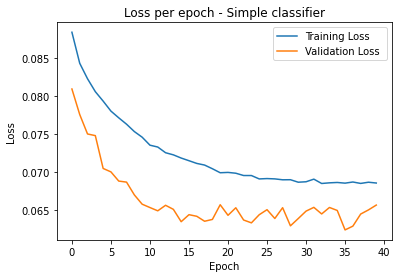

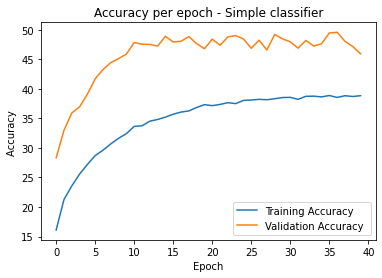

In [40]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.1796 
Testing Accuracy: 900/2000 (45.00%)
apple Class Accuracy: 26/100 (26.00%)
banana Class Accuracy: 47/100 (47.00%)
bear Class Accuracy: 62/100 (62.00%)
bell_pepper Class Accuracy: 36/100 (36.00%)
bird Class Accuracy: 48/100 (48.00%)
broccoli Class Accuracy: 54/100 (54.00%)
cat Class Accuracy: 29/100 (29.00%)
cauliflower Class Accuracy: 23/100 (23.00%)
cow Class Accuracy: 58/100 (58.00%)
dog Class Accuracy: 14/100 (14.00%)
elephant Class Accuracy: 49/100 (49.00%)
fox Class Accuracy: 59/100 (59.00%)
goat Class Accuracy: 22/100 (22.00%)
horse Class Accuracy: 44/100 (44.00%)
mashed_potato Class Accuracy: 52/100 (52.00%)
orange Class Accuracy: 42/100 (42.00%)
pineapple Class Accuracy: 54/100 (54.00%)
pomegranate Class Accuracy: 55/100 (55.00%)
tomato Class Accuracy: 61/100 (61.00%)
zebra Class Accuracy: 65/100 (65.00%)
Classifier has Acc=0.450 P=0.450 R=0.472 F1=0.448
               precision    recall  f1-score   support

        apple       0.35      0.26      0.30      

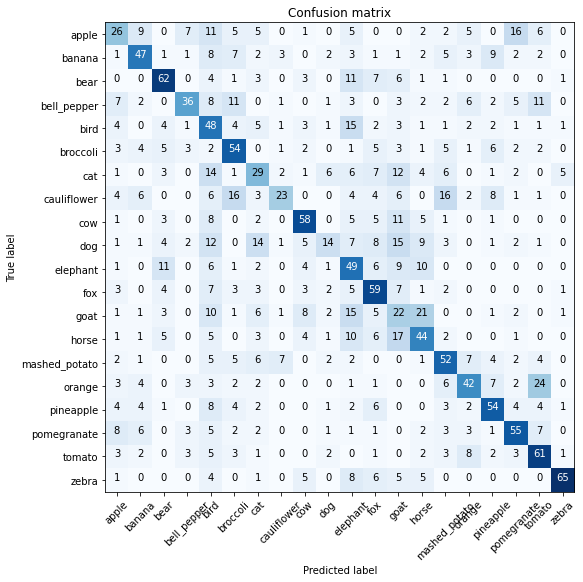

In [41]:
result = test_model(best_model, criterion, name)

In [ ]:
#test